<a href="https://colab.research.google.com/github/spotka/DHanalyticsb/main/doc_sim_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [395]:
!ls /content/drive/MyDrive/shera
!cp /content/drive/MyDrive/shera/2022txt.zip .
!unzip -oq 2022txt.zip 
path = '2022txt'

 2013txt.zip   2022gephi_0.25sim.csv		       doc2vec.bin.syn1neg.npy
 2014txt.zip   2022gephi.csv			       docnames.csv
 2015txt.zip   2022txt.zip			       docvecs.csv
 2016txt.zip   code_selenium			       fig
 2017txt.zip   code_zinoviev			       notesSh.txt
 2018txt.zip  'Copy of _digital_humanities_wiki.txt'   pdf
 2019txt.zip   _digital_humanities_wiki.txt	       sims
 2020txt.zip   doc2vec.bin			       year_com_areas.csv
 2021txt.zip   doc2vec.bin.syn0.npy


In [396]:
from pathlib import Path

all_txt_files =[]
for file in Path(f"./{path}/").rglob("*.txt"):
  all_txt_files.append(file.parent / file.name)

n_files = len(all_txt_files)
print(n_files)

258


In [397]:
# A pattern I use often is to load the text files into a pandas dataframe. 
# This is way I get consistent docid's of documents by using the dataframe index. 
# Also, we can later add useful columns to the dataframe, such as 'tokens', see later cells.  

import pandas as pd

# Initialize an empty list to store the data
data = []

# Loop through the file names
for filename in all_txt_files:
    # Read the file into a string
    with open(filename, 'r') as f:
        text = f.read()
    
    # Append the string to the list
    data.append( (filename, text) )

# Create a dataframe from the list of strings
docdf = pd.DataFrame(data, columns=['filename', 'text'])
docdf

,filename,text
0,2022txt/47.txt,Zaagsma – DHBenelux 2022 \n 1 Exploring the Hi...
1,2022txt/251.txt,"IDS SPRACHREPORT 1/2022 1Abhängig davon,..."
2,2022txt/56.txt,Call for Papers Title: Aesthetics of New Techn...
3,2022txt/39.txt,\nForum for \nWorld Literature Studies\nVol.13...
4,2022txt/27.txt,Presents: Coffee with the Editors!\nASIS&T’s E...
...,...,...
253,2022txt/8.txt,EUROGRAPHICS Workshop on Graphics and Cultural...
254,2022txt/11.txt,A Tool for Pseudonymization of Textual Documen...
255,2022txt/373.txt,РОССИЙСКАЯ АКАДЕМИЯ НАУК\nИнститут русского яз...
256,2022txt/270.txt,\nedited by\nMaria Ranieri\nLaura Menichetti\n...


In [398]:
# # create paragraphs
# import re
# docdf["paragraphs"] = docdf["text"].map(lambda text: re.split('\.\s*\n', text))
# docdf["number_of_paragraphs"] = docdf["paragraphs"].map(len)
# docdf

In [399]:
# # flatten the paragraphs
# docdf = pd.DataFrame([{ "text": paragraph} 
#                                for paragraphs in docdf["paragraphs"] 
#                                     for paragraph in paragraphs if paragraph])
# docdf

# TF/IDF

In [400]:
import nltk
nltk.download('stopwords')
english = nltk.corpus.stopwords.words('english')
german = nltk.corpus.stopwords.words('german')
spanish = nltk.corpus.stopwords.words('spanish')
italian = nltk.corpus.stopwords.words('italian')
french = nltk.corpus.stopwords.words('french')

stopwords = english + german + spanish + italian + french

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [401]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
# from spacy.lang.en.stop_words import STOP_WORDS as stopwords

tfidf = TfidfVectorizer(stop_words=stopwords, min_df=2)
dt = tfidf.fit_transform(docdf["text"])
print('Number of bytes', dt.data.nbytes)
dt
tfidf_text_vectors = dt

Number of bytes 6989208
CPU times: user 13.2 s, sys: 234 ms, total: 13.4 s
Wall time: 13.6 s


# Finding the most similar documents

### Timing Cosine Similarity

In [402]:
%%time
from sklearn.metrics.pairwise import cosine_similarity
r = cosine_similarity(dt, dt, dense_output=False)

CPU times: user 257 ms, sys: 2.94 ms, total: 260 ms
Wall time: 261 ms


# Creating the graph dataframe.

In [403]:
# Let's transform the sparse matrix to a pandas dataframe  
import pandas as pd

m = r.tocoo()
tuples = zip(m.row, m.col, m.data)
df = pd.DataFrame(tuples, columns =['docid1', 'docid2', 'score'])
df

# Filtering out duplicates. There are quite a few duplicates in the dataset. 
dup_pairs = df[ (0.99 < df['score']) & (df['docid1']<df['docid2']) ] 
# print( dup_pairs )
dup_list = dup_pairs['docid2'].tolist()
# print(dup_list)
df = df[~df['docid1'].isin(dup_list)]
df = df[~df['docid2'].isin(dup_list)]
# dup_pairs = df[ (0.99 < df['score']) & (df['docid1']<df['docid2']) ]
# print( dup_pairs )

# A: Let's keep only rows with similarity greater than a threshold. 
# A: The threshold is chosen so that we have an average degree of not more than 10.
# A: We set the threshold so that each document has on average about 30 neighbors wrt similarity
# A: Also, let's remove rows with similarity close to 1. These are self-similarities. 
threshold = 0.18
df = df[ threshold <= df['score'] ]
df = df[ 0.99 > df['score'] ]
df.reset_index(drop=True, inplace=True)
df

,docid1,docid2,score
0,0,243,0.207696
1,0,245,0.180299
2,0,115,0.278613
3,0,249,0.188920
4,0,221,0.216301
...,...,...,...
2741,256,243,0.209837
2742,256,244,0.186772
2743,256,245,0.331565
2744,257,145,0.354206


In [404]:
# Let's see the nodes with the most neighbors
print(df.groupby('docid1')['docid2'].count().sort_values(ascending=False).head(50))

docid1
43     113
80     113
221     88
177     83
88      82
240     65
40      60
256     59
231     58
32      52
208     51
170     44
22      41
14      39
126     38
153     37
245     35
239     34
162     33
105     33
252     31
118     31
173     29
224     29
68      29
100     29
17      28
253     28
5       28
99      28
200     28
87      27
96      27
107     25
117     24
52      24
86      23
55      23
61      23
3       22
101     22
111     20
232     20
79      20
235     20
72      20
103     19
30      19
186     18
144     17
Name: docid2, dtype: int64


# Remove nodes with very high degree

They are like stopwords. 
Most probably they are conference proceeding or full books.
They make the graph too dense and convoluted. In the future we should make as unit of analysis pages not full docs. 

In [405]:
# # Create a set of values to filter
# values_to_remove = {76,225}

# # Use boolean indexing to filter the rows
# df = df[~df['docid1'].isin(values_to_remove) & ~df['docid2'].isin(values_to_remove)]

# print(df.groupby('docid1')['docid2'].count().sort_values(ascending=False).head(50))

In [406]:
# https://stackoverflow.com/questions/74175462/attributeerror-module-scipy-sparse-has-no-attribute-coo-array
!pip install 'scipy>=1.8'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [407]:
import networkx as nx
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'docid1', 'docid2')

# To visualize the graph use Gephi, or see: https://nightingaledvs.com/how-to-visualize-a-graph-with-a-million-nodes/ 

In [408]:
nx.write_gexf(G, "2022.gexf")

In [409]:
# Exploring some nodes we see interesting from Gephi
print(docdf.iloc[104])

filename                         2022txt/2022.lchange-1.0.txt
text        LChange 2022\n3rd International Workshop on Co...
Name: 104, dtype: object


# Modularity community partitioning using NetworkX. 
Either comment out this cell which uses NetworkX or the next which uses Gephi.

Select the nodes of modularity class 0. This is the first class. 
Repeat for modularity class 1, 2, 3, 4.

Then, save as **Gephi** graph for visualization. Use the **modularity** attribute we save here for coloring nodes in Gephi. 

In [410]:
classnum = 0

In [411]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import networkx.algorithms.community as nx_comm

c = greedy_modularity_communities(G,weight='score')

print('modularity\t', nx_comm.modularity(G, c))
print('average clustering coefficient\t', nx.average_clustering(G, c[0]))
print('degree assortativity coefficient\t', nx.degree_assortativity_coefficient(G))
print('graph clique number\t', nx.graph_clique_number(G))

comlist = list(c[classnum])

print(f'Nodes of community {classnum}', comlist)

# Save as gephi graph for visualization
node_to_com = dict()
num_coms = len(c)
for com in range(num_coms):
  if com>4: 
    break; # only consider the top 5 coms, 0,1,2,3,4
  for node in c[com]:
    node_to_com[node] = com

nx.set_node_attributes(G, node_to_com, "modularity")
nx.write_gexf(G, "2022mod.gexf")

modularity	 0.2863310680595334
average clustering coefficient	 0.6829655796655761
degree assortativity coefficient	 -0.2734451483490444
graph clique number	 16
Nodes of community 0 [257, 2, 3, 5, 8, 9, 21, 25, 26, 27, 31, 33, 36, 42, 43, 44, 45, 48, 51, 58, 61, 63, 67, 68, 69, 72, 75, 78, 80, 81, 85, 87, 89, 90, 95, 97, 98, 102, 104, 107, 108, 113, 114, 115, 122, 123, 125, 126, 134, 141, 144, 145, 146, 147, 148, 149, 150, 151, 153, 157, 158, 162, 164, 166, 174, 177, 181, 182, 185, 188, 202, 210, 214, 215, 216, 221, 233, 234, 235]


# Get modularity community partitioning using Gephi.
In Gephi go to Data Laboratory and save as csv. 
Now put it somewhere, e.g. /content/drive/MyDrive/shera/2022gephi.csv and read it to a dataframe. 

Select the nodes of modularity class 0. This is the first class. 
Repeat for modularity class 1, 2, 3, 4.

In [412]:
# comdf = pd.read_csv('/content/drive/MyDrive/shera/2022gephi.csv')
# comlist = comdf[ comdf['modularity_class']==classnum ]['Id'].tolist()  
# print(comlist)

# Build wordmap for the selected community. 

In [413]:
# extract rows from docdf with ids in comlist
docdf_com = docdf.iloc[ comlist ]
docdf_com

,filename,text
257,2022txt/62.txt,https://helda.helsinki.fi\nOptimizing the weig...
2,2022txt/56.txt,Call for Papers Title: Aesthetics of New Techn...
3,2022txt/39.txt,\nForum for \nWorld Literature Studies\nVol.13...
5,2022txt/178.txt,\n \n \n Hidden Cities \nThis groundbreaking c...
8,2022txt/143.txt,\t Interfacing Collaborative and Multiple-Laye...
...,...,...
216,2022txt/95.txt,kykRX h?Bb rQ`F Bb HB+2Mb2/ mM/2` *`2 iBp2 *...
221,2022txt/82.txt,DH_BUDAPEST_2022\nDigital Humanities Conferenc...
233,2022txt/227.txt,TEI Advances for Concordance Compiling: \na c...
234,2022txt/147.txt,\n \nJournal of Cultural Analytics 7.2 (2022...


In [414]:
import regex as re
import nltk
from nltk.stem import PorterStemmer

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)


nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(['learners', 'also', 'https'])

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

def porter_stem(tokens):
  ps = PorterStemmer()
  return [ps.stem(t) for t in tokens]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

docdf_com['tokens'] = docdf_com['text'].apply(prepare, pipeline=pipeline)
# keeping only tokens with length >= 4
docdf_com['tokens'] = docdf_com['tokens'].apply(lambda li : [x for x in li if len(x)>=4])
docdf_com

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-414-99ca46edc46d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docdf_com['tokens'] = docdf_com['text'].apply(prepare, pipeline=pipeline)
<ipython-input-414-99ca46edc46d>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docdf_com['tokens'] = docdf_com['tokens'].apply(lambda li : [x for x in li if len(x)>=4])


,filename,text,tokens
257,2022txt/62.txt,https://helda.helsinki.fi\nOptimizing the weig...,"[helda, helsinki, optimizing, weighted, sequen..."
2,2022txt/56.txt,Call for Papers Title: Aesthetics of New Techn...,"[call, papers, title, aesthetics, technologica..."
3,2022txt/39.txt,\nForum for \nWorld Literature Studies\nVol.13...,"[forum, world, literature, studies, december, ..."
5,2022txt/178.txt,\n \n \n Hidden Cities \nThis groundbreaking c...,"[hidden, cities, groundbreaking, collection, e..."
8,2022txt/143.txt,\t Interfacing Collaborative and Multiple-Laye...,"[interfacing, collaborative, multiple-layered,..."
...,...,...,...
216,2022txt/95.txt,kykRX h?Bb rQ`F Bb HB+2Mb2/ mM/2` *`2 iBp2 *...,"[kykrx, 2mb2, ibp2, qkkqmb, mibqm, ami2, ibqm,..."
221,2022txt/82.txt,DH_BUDAPEST_2022\nDigital Humanities Conferenc...,"[dh_budapest_2022, digital, humanities, confer..."
233,2022txt/227.txt,TEI Advances for Concordance Compiling: \na c...,"[advances, concordance, compiling, case, study..."
234,2022txt/147.txt,\n \nJournal of Cultural Analytics 7.2 (2022...,"[journal, cultural, analytics, 001c, journal, ..."


In [415]:
# Counting tokens
from collections import Counter

counter = Counter()

# Call counter.update for each row of the column tokens. 
# Counter will be updated each time. 
_ = docdf_com['tokens'].map(counter.update) 
print(counter.most_common(20))

[('digital', 4473), ('data', 4196), ('research', 4165), ('language', 3004), ('university', 2405), ('social', 2262), ('analysis', 2216), ('history', 1986), ('studies', 1956), ('heritage', 1932), ('corpus', 1906), ('text', 1890), ('information', 1860), ('different', 1856), ('world', 1856), ('used', 1719), ('cultural', 1568), ('time', 1555), ('work', 1550), ('study', 1527)]


In [416]:
# transform counter into data frame
min_freq = 2
freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
freq_df = freq_df.query('freq >= @min_freq')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(20)

,freq
token,
digital,4473
data,4196
research,4165
language,3004
university,2405
social,2262
analysis,2216
history,1986
studies,1956


In [417]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

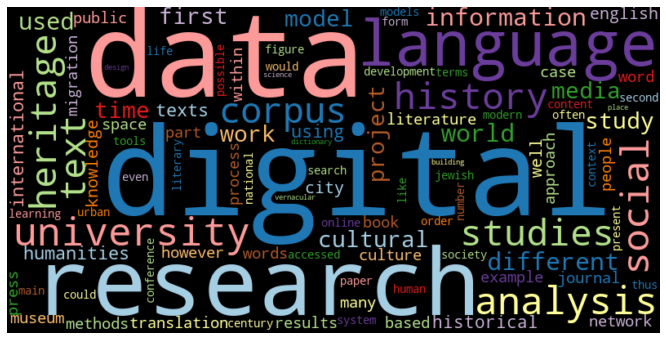

In [418]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
wordcloud(freq_df['freq'], max_words=100)    

<ipython-input-419-c92838ac73fd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


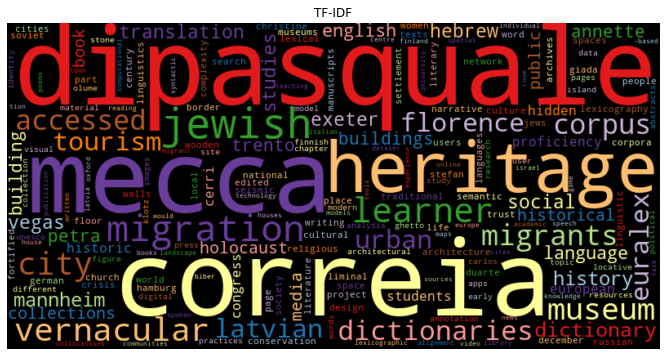

In [419]:
import numpy as np

def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

idf_df = compute_idf(docdf_com)
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
wordcloud(freq_df['tfidf'], title='TF-IDF', stopwords=['https', 'http'])

## Topic Extraction using NMF

In [420]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=15, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors[comlist])
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [421]:
def display_topics(model, features, no_top_words=7):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

display_topics(nmf_text_model, tfidf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Topic 00
  art (0.98)
  digital (0.94)
  visual (0.66)
  talents (0.50)
  images (0.49)
  imaging (0.30)
  ireland (0.30)

Topic 01
  alignment (2.13)
  pairs (0.47)
  models (0.46)
  similarity (0.44)
  quotes (0.42)
  matrix (0.42)
  algorithm (0.41)

Topic 02
  translation (2.47)
  studies (0.56)
  intensional (0.56)
  felt (0.51)
  translator (0.49)
  big (0.45)
  data (0.44)

Topic 03
  graph (0.72)
  data (0.59)
  figure (0.45)
  nodes (0.42)
  network (0.42)
  codex (0.41)
  xml (0.38)

Topic 04
  heritage (0.49)
  city (0.43)
  museum (0.41)
  maps (0.35)
  dipasquale (0.34)
  urban (0.31)
  correia (0.30)

Topic 05
  game (1.40)
  twitch (1.01)
  kremer (0.96)
  games (0.91)
  gamers (0.72)
  video (0.70)
  streaming (0.56)

Topic 06
  latvian (2.04)
  language (1.20)
  lt (0.79)
  european (0.60)
  speech (0.45)
  languages (0.43)
  latvia (0.43)

Topic 07
  films (0.96)
  model (0.77)
  finnish (0.76)
  movie (0.66)
  movies (0.63)
  cars (0.54)
  data (0.46)

Topic 08
  so

In [422]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([5.03619556, 5.16754909, 6.06691808, 8.9537193 , 6.0156617 ,
       4.99660632, 5.21472873, 6.12014736, 9.53689463, 7.94231466,
       5.10652005, 6.93532634, 5.94814086, 9.32468702, 7.6345903 ])

**Some conclusions about community 0 using Gephi.** 
These word maps could suggest a community of documents related to law, public policy, and digital tools. For example, document 100 (2022txt/243.txt) is about law practice in Ukraine and includes a considerable number of articles information law in Ukraine. Document 207 (2022txt/178.txt) is about public policy, museum placement, political conflict, and other societal matters. Finally, Robin Wharton is a medievalist, digital humanist, and attorney.   

# TODO
Somehow the topics discovered via wordmaps are too general. How about using the topic discovery chapter in the Blueprints book, and having each page of each document as unit rather than the whole document. The Blueprint chapter suggests paragraphs as units, but it is not easy to extract paragraphs from text extracted from pdf, unless we use a better pdf-to-txt library, such as PDFTRON: https://www.pdftron.com/documentation/python/get-started/python3/windows,

https://www.pdftron.com/documentation/python/get-started/python3/windows/#integrate-into-your-application 

https://www.pdftron.com/documentation/samples/py/TextExtractTest
(Here they extract paragraphs and store them in XML files) 